In [13]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from yellowbrick.target import FeatureCorrelation
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [14]:
df = pd.read_csv('data.csv')

df_kaggle = pd.read_csv('data_kaggle.csv')
df_kaggle.rename(columns={'artist_name':'artist', 'track_name':'name', 'track_id':'id'}, inplace=True)
df_kaggle.drop_duplicates(inplace=True)

print(df.shape)
print(df_kaggle.shape)

(62179, 19)
(232725, 19)


In [15]:
df_ids = df['id'].values.tolist()
df_kaggle_ids = df_kaggle['id'].values.tolist()
ids_to_drop = set(df_ids).intersection(set(df_kaggle_ids))

df.drop(df[df.id.isin(ids_to_drop)].index, inplace=True)

df = df.append(df_kaggle)
df.reset_index(drop=True, inplace=True)

print(len(ids_to_drop))
print(df.shape)

19480
(275424, 19)


In [16]:
df['duration_min'] = df['duration_ms']/60000
df['duration_min'] = df['duration_min'].round(2)

In [17]:
def validate(row):
    try:
        datetime.datetime.strptime(row.release_date, '%Y-%m-%d')
        return True
    except ValueError:
        return False

df = df[df.apply(lambda x: validate(x), axis = 1)]
df['year'] = pd.DatetimeIndex(df['release_date']).year
df = df.drop(labels=['duration_ms', 'release_date'], axis=1)
df = df[df['year'] >= 1960]
df = df[df['year'] < 2020]

In [18]:
df['decade'] = None
df.loc[(df['year'] >= 1960) & (df['year'] < 1970), 'decade'] = '1960s'
df.loc[(df['year'] >= 1970) & (df['year'] < 1980), 'decade'] = '1970s'
df.loc[(df['year'] >= 1980) & (df['year'] < 1990), 'decade'] = '1980s'
df.loc[(df['year'] >= 1990) & (df['year'] < 2000), 'decade'] = '1990s'
df.loc[(df['year'] >= 2000) & (df['year'] < 2010), 'decade'] = '2000s'
df.loc[(df['year'] >= 2010) & (df['year'] < 2020), 'decade'] = '2010s'

In [19]:
df.decade.value_counts()

2010s    175243
2000s     46246
1990s     17157
1980s      5067
1970s      4651
1960s      2211
Name: decade, dtype: int64

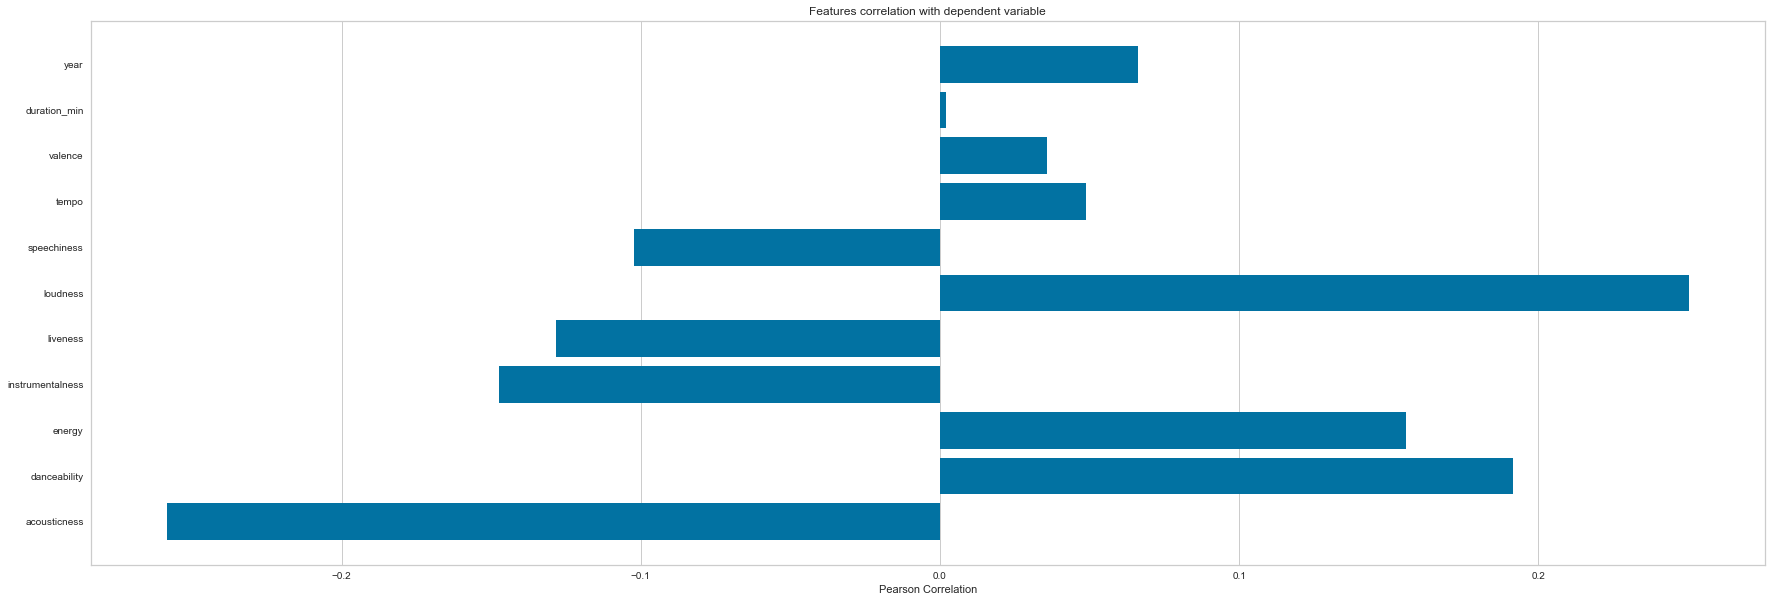

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [20]:
feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_min','year']

X, y = df[feature_names], df['popularity']

features = np.array(feature_names)
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(30,10)
visualizer.fit(X, y)
visualizer.show()  

In [21]:
# data = df
# data['popularity'] = pd.cut(data.popularity, bins=4, labels=['low','medium','high','very high'], right=True)
# y = data.popularity
# y.value_counts()/y.count()

In [22]:
ros = RandomOverSampler()
X = df[feature_names]
y = df['popularity']
X_ros, y_ros = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, random_state=42, test_size=0.2)

knn = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=1))

knn.fit(X_train, y_train)
knn.score(X_test, y_test)


0.9738876963938975

In [23]:
rf = RandomForestRegressor(n_estimators=10, max_depth=8, min_samples_leaf=8)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.6121406905197116

In [24]:
print(X.shape)
print(y.shape)

(250575, 11)
(250575,)
